In [3]:
import os, random, re
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time, datetime, gc

import shutil

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.applications.inception_v3 import InceptionV3

from keras import backend as K

Using TensorFlow backend.


## FS Shenanigans

In [4]:
input_directory = 'chest_xray/'
output_directory = 'output/'

training_dir = input_directory + 'train'
testing_dir = input_directory + 'test'

def create_directory(directory_path, remove=False):
	if remove and os.path.exists(directory_path):
		try:
			shutil.rmtree(directory_path)
			os.mkdir(directory_path)
		except:
			print('Could not remove directory : ', directory_path)
			return False
	else:
		try:
			os.mkdir(directory_path)
		except:
			print('Could not create directory: ', directory_path)
			return False
		
	return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
	if os.path.exists(directory_path):
		try:
			shutil.rmtree(directory_path)
		except:
			print('Could not remove directory : ', directory_path)
			return False
		
	return True

def clear_directory(directory_path):
	dirs_files = os.listdir(directory_path)
	
	for item in dirs_files:
		item_path = directory_path + item
		
		try:
			if os.path.isfile(item_path):
				os.unlink(item_path)
			elif os.path.isdir(item_path): 
				shutil.rmtree(item_path)
		except Exception as e:
			print(e)
			
	return True


def remove_empty_folders(path, removeRoot=True):
	if not os.path.isdir(path):
		return
	
	# remove empty subfolders
	files = os.listdir(path)
	
	if len(files):
		for f in files:
			fullpath = os.path.join(path, f)
			
			if os.path.isdir(fullpath):
				remove_empty_folders(fullpath)

	# if folder empty, delete it
	files = os.listdir(path)
	
	if len(files) == 0 and removeRoot:
		print('Removing empty folder:', path)
		os.rmdir(path)


def dir_file_count(directory):
	return sum([len(files) for r, d, files in os.walk(directory)])

## Plotting and other helper functions

In [5]:
def name_correct(name):
	return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

def get_reset_subplot_params(nrows, ncols, dpi):
	subplot_params = dict()
	subplot_params['nrows'] = nrows
	subplot_params['ncols'] = ncols

	subplot_params['figsize_col'] = subplot_params['ncols']*2.5
	subplot_params['figsize_row'] = subplot_params['nrows']*2.5
	subplot_params['dpi'] = dpi
	subplot_params['facecolor'] = 'w'
	subplot_params['edgecolor'] = 'k'
	subplot_params['subplot_kw'] = {'xticks': [], 'yticks': []}
	subplot_params['axes.titlesize'] = 'small'
	subplot_params['hspace'] = 0.5
	subplot_params['wspace'] = 0.3
	
	return subplot_params

def get_reset_plot_params(figsize=(15, 5), title='', xlabel ='', ylabel='', legends=[],
                          title_fontsize = 18, label_fontsize = 14, image_file_name='',
                          save = False, dpi=100, update_image=True):
	plot_params = {}
	
	plot_params['figsize'] = figsize
	
	plot_params['title'] = title
	
	plot_params['xlabel'] = xlabel
	plot_params['ylabel'] = ylabel
	
	plot_params['legends'] = legends 
	
	plot_params['title_fontsize'] = title_fontsize
	plot_params['axes.titlesize'] = 'small'
	plot_params['label_fontsize'] = label_fontsize
	
	plot_params['image_file_name'] = image_file_name
	plot_params['save'] = save
	plot_params['update_image'] = update_image
	
	plot_params['subplot'] = None
	return plot_params

def select_image_by_category(image_dir, image_count_per_category):
	classes = os.listdir(image_dir)
	class_count = len(classes)

	image_file_paths = {}
	
	for i in range(class_count):
		subdir_path = image_dir+'/'+classes[i]
		subdir_files = os.listdir(subdir_path)

		subdir_file_count = len(subdir_files)

		subdir_file_mem = {}
		
		subdir_file_index = -1
		
		image_file_paths[classes[i]] = []
		
		for j in range(image_count_per_category):
			while subdir_file_index in subdir_file_mem:
				subdir_file_index = random.randint(0, subdir_file_count-1)
				
			subdir_file_mem[subdir_file_index] = 1
			
			subdir_file_name = subdir_files[subdir_file_index]
			subdir_file_path = subdir_path+ '/' + subdir_file_name

			image_file_paths[classes[i]].append(subdir_file_path)
			
	return image_file_paths


def get_fig_axs(subplot_params):
	fig, axs = plt.subplots(
		nrows=subplot_params['nrows'], ncols=subplot_params['ncols'], 
		figsize=(subplot_params['figsize_col'], subplot_params['figsize_row']),
		dpi=subplot_params['dpi'], facecolor=subplot_params['facecolor'], 
		edgecolor=subplot_params['edgecolor'], subplot_kw=subplot_params['subplot_kw'])
		
	return fig, axs


# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
	subdirectories = os.listdir(master_directory)
	subdirectory_count = len(subdirectories)

	subdirectory_names = []
	subdirectory_file_counts = []

	for subdirectory in subdirectories:
		current_directory = os.path.join(master_directory, subdirectory)
		file_count = len(os.listdir(current_directory))
		subdirectory_names.append(subdirectory)
		subdirectory_file_counts.append(file_count)
	
	return subdirectory_names, subdirectory_file_counts
		 
	

# show barplot
def bar_plot(x, y, plot_property):
	if plot_property['subplot']:
		plt.subplot(plot_property['subplot'])
	sns.barplot(x=x, y=y)
	plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
	plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
	plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
	plt.xticks(range(len(x)), x)
	
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
	dir_name, dir_file_count = subdirectory_file_count(master_directory)
	x = [name_correct(i) for i in dir_name]
	# x = dir_name
	y = dir_file_count
	bar_plot(x, y, plot_property)
	
	
# show bar plot for count of labels in subdirectory of a training, testing directory	
def show_train_test(training_dir, testing_dir, plot_property):
	plt.figure(figsize=plot_property['figsize'])
	
	title = plot_property['title']
	plot_property['title'] = title + ' (Training)'
	subplot_no = plot_property['subplot']
	count_bar_plot(training_dir, plot_property)
	
	plot_property['title'] = title + ' (Testing)'
	plot_property['subplot'] = subplot_no + 1
	count_bar_plot(testing_dir, plot_property)
	
	plt.show()
	

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
	fig, axs = get_fig_axs(subplot_params)

	plt.rcParams.update({'axes.titlesize': plot_params['axes.titlesize']})
	plt.subplots_adjust(hspace=subplot_params['hspace'], wspace=subplot_params['wspace'])


	i=0
	for img_filepath in image_file_paths:
		img = cv2.imread(img_filepath, 1)
		plt.title(img_filepath.split('/')[-1])
		plt.subplot(subplot_params['nrows'], subplot_params['ncols'], i+1)
		plt.imshow(img)
		
		plt.xticks([])
		plt.yticks([])
		
		i=i+1
		
	if plot_params['update_image'] and os.path.exists(plot_params['image_file_name']):
		os.remove(plot_params['image_file_name'])  
	if plot_params['save']:
		fig.savefig(plot_params['image_file_name'], dpi=plot_params['dpi'])
		
	plt.tight_layout()
	plt.show()
	
	
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
	class_count = len(os.listdir(directory))
	print('Number of Class: ', class_count)
	sample_img_by_class = select_image_by_category(directory, image_count_per_category)

	for class_name in sample_img_by_class:
		plot_params = get_reset_plot_params(image_file_name='img.png', save = save, dpi=dpi, update_image=update_image)
		subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)

		print('%s%s%s'%('-'*55, name_correct(class_name), '-'*55))
		plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
		print('')

	print('%s%s%d%s'%('-'*55, 'All Class Printed:', class_count, '-'*55))

# Data Visualization

Number of Class:  2
-------------------------------------------------------Normal-------------------------------------------------------


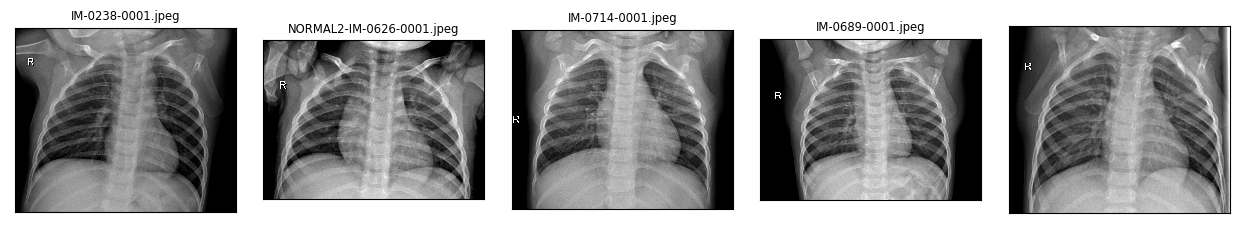


-------------------------------------------------------Pneumonia-------------------------------------------------------


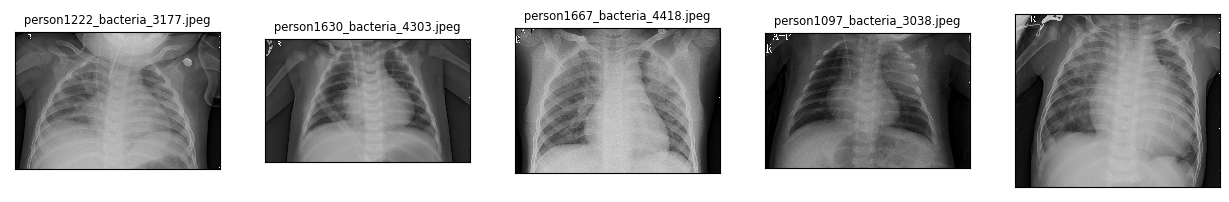


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [6]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

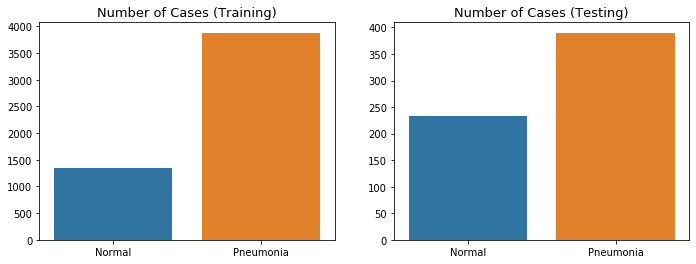

In [7]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = 'Number of Cases'

plot_params['subplot'] = 131

show_train_test(training_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

# Tensorflow Section
## Data Generators

In [8]:
rescale = 1./255
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
	rescale=rescale,
	shear_range=0.2,
	zoom_range=0.2,
	horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
	training_dir,
	target_size=target_size,
	class_mode=class_mode,
	batch_size=batch_size,
	shuffle=True)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
	testing_dir,
	target_size=target_size,
	class_mode=class_mode,
	batch_size=dir_file_count(testing_dir),
	shuffle=False)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Class weights for to fight class-imbalance

In [9]:
from sklearn.utils import class_weight
def get_weight(y):
	class_weight_current = class_weight.compute_class_weight('balanced', np.unique(y), y)
	return class_weight_current

class_weight = get_weight(train_generator.classes)
print(class_weight)

[1.93921423 0.6737059 ]


## Prep

In [10]:
main_model_dir = output_directory + 'models/'
main_log_dir = output_directory + 'logs/'

clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + '/'
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + '{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5'

In [11]:
def reset_tf_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    tf.reset_default_graph()
    K.clear_session()
    gc.collect()
    return True

def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

reset_tf_graph()
reset_callbacks()

W0927 13:17:21.259117 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0927 13:17:21.260118 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0927 13:17:21.275417 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



## Keras Callbacks

In [15]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=10,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

## Setup transfer learning model based on InceptionV3

In [13]:
def get_model():    
	base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

	x = base_model.output    
	x = BatchNormalization()(x)
	x = Flatten()(x)
	x = Dense(256, activation='relu')(x)
	x = Dropout(0.5)(x)
	predictions = Dense(2, activation='softmax')(x)
	
	model = Model(inputs=base_model.input, outputs=predictions)
	
	for layer in base_model.layers:
		layer.trainable = False

	model.summary()
	return model

model = get_model()

W0927 13:17:26.263684 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 13:17:26.265686 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 13:17:27.501847 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0927 13:17:27.664003 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0927 13:17:28.199612

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Training

In [16]:
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator) # Abusing test set for validation. Shouldn't matter much tho.

optimizer = keras.optimizers.Adadelta()
loss = 'binary_crossentropy'
metrics = ['accuracy']
epochs = 100

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=test_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

W0927 13:18:01.808044 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 13:18:01.815051 21168 deprecation.py:323] From f:\pythonenvironments\machinelearning\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0927 13:18:03.119680 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0927 13:18:03.120681 21168 deprecation_wrapper.py:119] From f:\pythonenvironments\machinelearning\lib\site-packages\keras\callbacks.py:853: The name tf.s

Epoch 1/100
 - 92s - loss: 0.9007 - acc: 0.8529 - val_loss: 4.1965 - val_acc: 0.6827
Epoch 2/100


f:\pythonenvironments\machinelearning\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109125). Check your callbacks.
  % delta_t_median)


 - 68s - loss: 0.3744 - acc: 0.8914 - val_loss: 3.4310 - val_acc: 0.7436
Epoch 3/100
 - 74s - loss: 0.3053 - acc: 0.9032 - val_loss: 3.6544 - val_acc: 0.7388
Epoch 4/100
 - 71s - loss: 0.2788 - acc: 0.9083 - val_loss: 5.0111 - val_acc: 0.6715
Epoch 5/100
 - 73s - loss: 0.2538 - acc: 0.9135 - val_loss: 5.4107 - val_acc: 0.6506
Epoch 6/100
 - 71s - loss: 0.2472 - acc: 0.9173 - val_loss: 5.3567 - val_acc: 0.6522
Epoch 7/100
 - 72s - loss: 0.2380 - acc: 0.9156 - val_loss: 4.2642 - val_acc: 0.7196
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping


## Evaluation

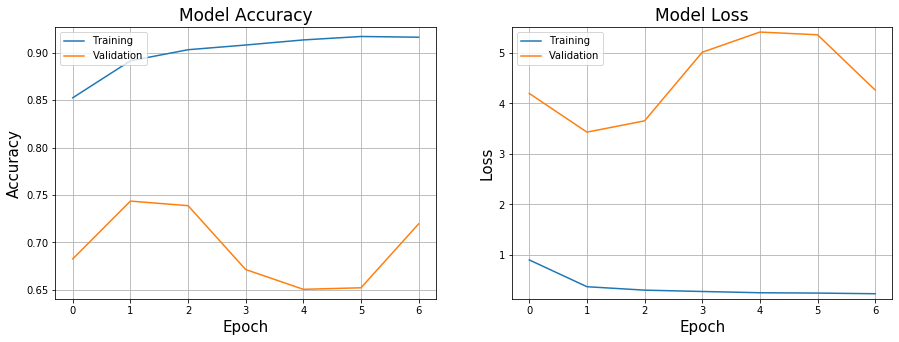

In [17]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]

plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values
y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]

plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

           
# Plot training & validation loss values
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]

plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

# Testing section

### Can be executed independently of above code.

In [18]:
import os, random, re
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time, datetime, gc

import shutil

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

from keras import backend as K

Found 624 images belonging to 2 classes.
Results:
1/1 [==============================] - 7s 7s/step
Loss     : 3.74  
Accuracy : 71.79%
1/1 [==============================] - 8s 8s/step
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 73.26%
Recall        : 86.41%
F1-Score      : 79.29%
------------------------------------------------------------------------------------------





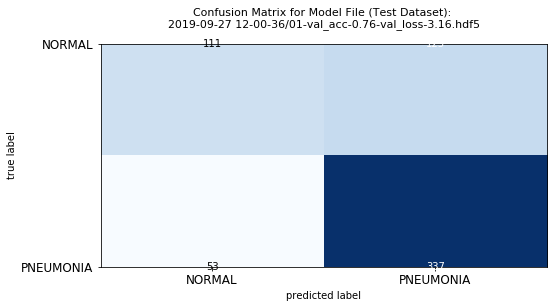




------------------------------------------------------------------------------------------
Report for Model File:  2019-09-27 12-00-36/01-val_acc-0.76-val_loss-3.16.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.68      0.47      0.56       234
   PNEUMONIA       0.73      0.86      0.79       390

    accuracy                           0.72       624
   macro avg       0.70      0.67      0.68       624
weighted avg       0.71      0.72      0.70       624

------------------------------------------------------------------------------------------


In [19]:
rescale = 1./255
target_size = (150, 150)
batch_size = 128
class_mode = 'categorical'
testing_dir = 'chest_xray/test'

test_datagen = ImageDataGenerator(rescale=rescale)

def dir_file_count(directory):
	return sum([len(files) for r, d, files in os.walk(directory)])

test_generator = test_datagen.flow_from_directory(
	testing_dir,
	target_size=target_size,
	class_mode=class_mode,
	batch_size=dir_file_count(testing_dir),
	shuffle=False)

model_file = './output/models/2019-09-27 12-00-36/01-val_acc-0.76-val_loss-3.16.hdf5'
model = keras.models.load_model(model_file)

print("Results:")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes
classes = ['NORMAL', 'PNEUMONIA']

image_file_name_CM = 'output/figures/CM'

title = model_file.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=11)
fig.savefig(image_file_name_CM, dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

#cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [23]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 71.79%
-----------------------------------


## Running inference on actual xray images

In [24]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = dict()
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1

        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"\\"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

In [25]:
image_file_name_batch = 'output/figures/result'
image_file_name_sample = 'output/figures/sample'

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}

dpi=100
ncols, nrows = 8, 4
count = ncols * nrows

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

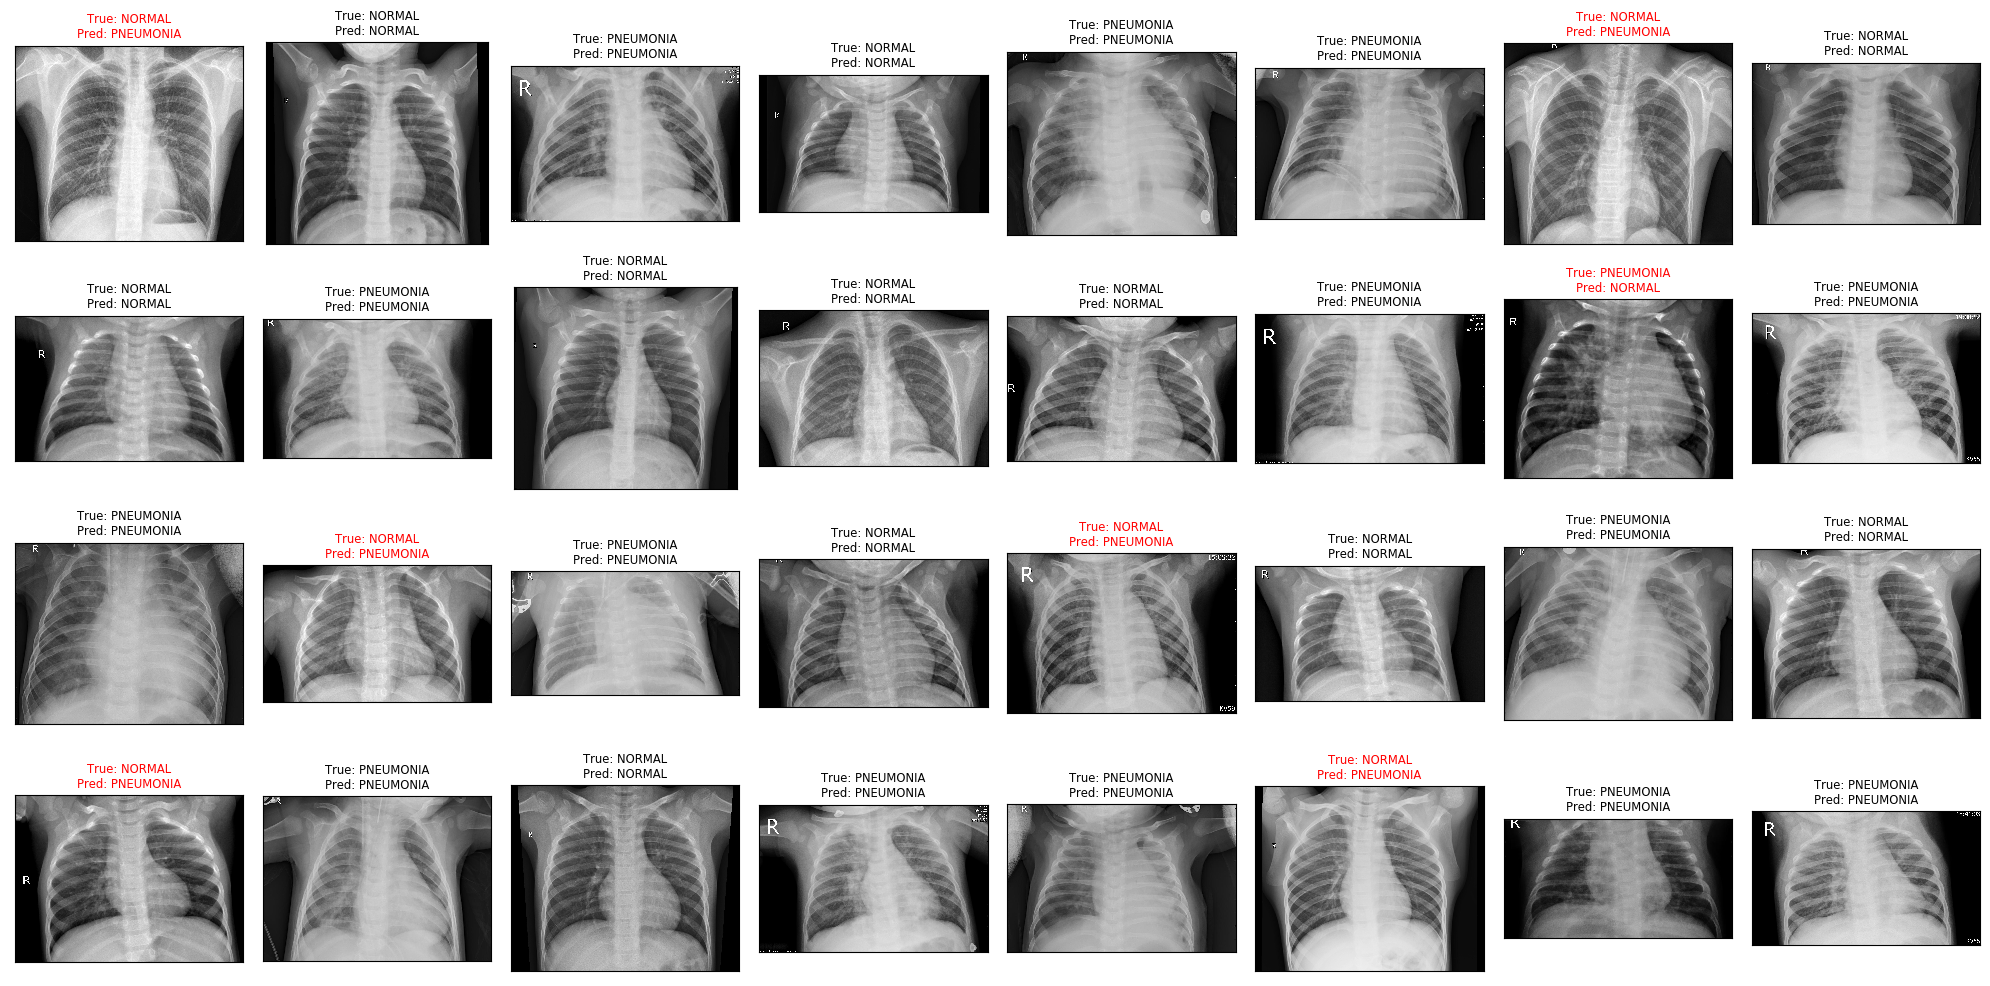

In [26]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)